##Challenge
Apply a supervised or semi-supervised ULMFiT model to Twitter US Airlines Sentiment

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings("ignore")
from fastai.text import *
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

##Loading Data

In [3]:
tweet = pd.read_csv('Tweets.csv')
tweet.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
tweet.shape

(14640, 15)

There are many columns, we only need 'airline_sentiment' and 'text' for the sentiment analysis

In [5]:
df = tweet[['airline_sentiment', 'text']]
df.sample(5)

,airline_sentiment,text
490,positive,@VirginAmerica you guys are perfect as always!...
5046,neutral,@SouthwestAir CEO using #Vegas band to help ‘c...
14102,negative,@AmericanAir You have the worst customer servi...
6038,positive,@SouthwestAir - thanks to the agent boarding 1...
12215,neutral,@AmericanAir please email me at temorris2010@h...


##Data analysis and preprocessing

Checking for the missing values

In [6]:
df.shape

(14640, 2)

In [7]:
df.isna().sum()

airline_sentiment    0
text                 0
dtype: int64

In [8]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [9]:
df['text'].value_counts()

@united thanks                                                                                                                        6
@SouthwestAir sent                                                                                                                    5
@AmericanAir thanks                                                                                                                   5
@JetBlue thanks!                                                                                                                      5
@AmericanAir thank you!                                                                                                               4
                                                                                                                                     ..
@AmericanAir @USAirways need to be reported to the @BBB_media for their complete disregard for paying customers! #DoNotFlyWithThem    1
@united thank you for getting our daughter home 

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64


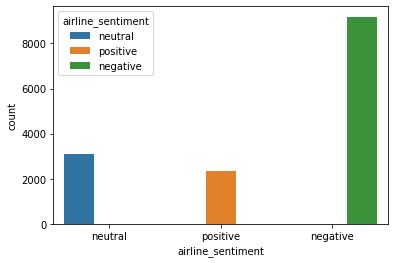

In [10]:
sns.countplot(x=df['airline_sentiment'], hue=df['airline_sentiment'])
print(df['airline_sentiment'].value_counts(normalize=True))

Around 62% tweets are negitive, 21% neutral and 16% positive.

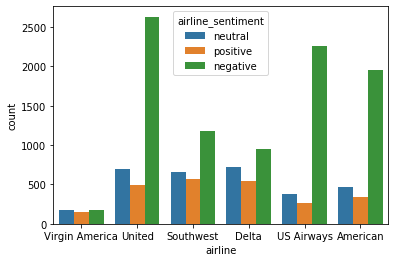

In [11]:
sns.countplot(x='airline', hue='airline_sentiment', data=tweet)

Negative sentiments are quite a lot for united airline, so if united is present then model may learn to associate it with negitive class.

Let's see the top words appearing in positive,negitive and neutral sentiments

In [12]:
top = 10
Counter("".join(df[df['airline_sentiment']=='positive'].text).split()).most_common(top)

[('the', 924),
 ('to', 923),
 ('for', 658),
 ('I', 570),
 ('a', 501),
 ('you', 486),
 ('and', 416),
 ('on', 327),
 ('my', 320),
 ('in', 307)]

In [13]:
Counter("".join(df[df['airline_sentiment']=='negative'].text).split()).most_common(top)

[('to', 5960),
 ('the', 3928),
 ('I', 3368),
 ('a', 3085),
 ('and', 2685),
 ('for', 2662),
 ('on', 2577),
 ('my', 2225),
 ('you', 2070),
 ('is', 1956)]

In [14]:
Counter("".join(df[df['airline_sentiment']=='neutral'].text).split()).most_common(top)

[('to', 1645),
 ('I', 1103),
 ('the', 927),
 ('a', 770),
 ('on', 630),
 ('you', 610),
 ('for', 597),
 ('my', 490),
 ('in', 443),
 ('and', 443)]

Removing airline tags

In [15]:
airlines = tweet['airline'].unique()
airlines

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways', 'American'], dtype=object)

In [16]:
pattern = r'@[\w]+'
func = lambda x:re.sub(pattern, '', x)
df['text'] = df['text'].apply(func)
df.sample(5)

,airline_sentiment,text
418,negative,Your back of seat entertainment system does n...
11907,negative,r u serious?? 304min #delay with #AmericanAir...
1158,neutral,After speaking to a United customer service r...
11138,neutral,yes travel is complete flight 5095 from CLT t...
486,negative,Umm so no reason as to why this is? Is there ...


##Model Building

In [0]:
train, valid = train_test_split(df, test_size=0.25)
data_lm = TextLMDataBunch.from_df('./', train, valid)
moms = (0.8,0.7)
wd = 0.1

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 5.25E-02


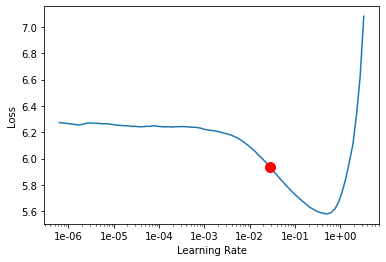

In [19]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [20]:
learn.fit_one_cycle(1, 2.75E-02, moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,4.484335,3.964986,0.266708,00:10


In [21]:
learn.unfreeze()
learn.fit_one_cycle(5, 2.75E-02, moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,3.991646,3.974410,0.265748,00:13
1,3.977119,3.904715,0.277199,00:14
2,3.793224,3.848529,0.284330,00:14
3,3.435606,3.799407,0.290993,00:14
4,2.800979,3.868923,0.296049,00:14



The accuracy of AWD Lstm is 29% which is fine as the network tries to predict next word

In [22]:
learn.predict('It was a decent experience', n_words=10)
            

'It was a decent experience of 2 hours red landing . Returning after a'

In [23]:
learn.predict('Service was not that great', n_words=10)

'Service was not that great ! feel like planning on Flight Booking'

In [0]:
learn.save_encoder('encoder.pth')

##Building the classifier
For building classifier we will eliminate the decoder network and use only the trained encoder network as the classifier

In [25]:
classifier = TextClasDataBunch.from_df('./', train, valid, test_df=df, vocab=data_lm.train_ds.vocab,
                                          label_cols='airline_sentiment', text_cols='text')
classifier.show_batch()

text,target
xxbos i xxup just xxup asked xxup my xxup boyfriend xxup to xxup prom xxup over xxup the xxup xxunk xxup on xxup flight 494 xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,positive
"xxbos xxmaj hi , i m flying xxup sfo - xxup lax - xxup xxunk - xxup xxunk . xxmaj my connecting time in xxup lax is xxunk m . xxmaj is it enough time ? xxmaj do i have to collect my bag and recheck on xxup xxunk ?",neutral
xxbos - xxmaj kids left a kindle fire xxup xxunk 6 onboard xxup xxunk ( xxup ord - xxup sfo ) today . xxmaj row xxup xxunk - xxup def ( we had the whole row amongst the 5 of us ) . xxmaj help ...,neutral
xxbos xxmaj aww xxmaj thanks xxup aa .. xxup dfw was on xxup gma up here this xxup am .. so i understand .. xxmaj btw xxup a.a is my xxmaj airline when i m able to trv .. xxmaj love you guys . : ),positive
xxbos xxmaj aww xxmaj thanks xxup aa .. xxup dfw was on xxup gma up here this xxup am .. so i understand .. xxmaj btw xxup a.a is my xxmaj airline when i m able to trv .. xxmaj love you guys . : ),positive


##Training classifier on our corpus

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03
Min loss divided by 10: 6.31E-02


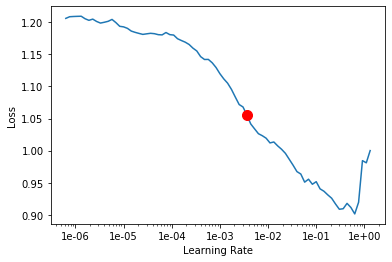

In [26]:
learn = text_classifier_learner(classifier, AWD_LSTM, drop_mult=0.3)
learn.load_encoder('encoder.pth')
learn.freeze()

learn.lr_find()
learn.recorder.plot(suggestion=True)

In [27]:
learn.fit_one_cycle(1, 3.02E-03, moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.622773,0.573873,0.789344,00:06



Training last two layers

In [28]:
learn.freeze_to(-2)
lr = 3.63E-03 / 5
learn.fit_one_cycle(1, slice(lr/2**4, lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.562873,0.534074,0.799727,00:07



Unfreezing one more layer

In [29]:
learn.freeze_to(-3)
lr /= 2
learn.fit_one_cycle(1, slice(lr/(2.6**4), lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.527394,0.511071,0.802186,00:12


Unfreezing whole network and training

In [30]:
learn.unfreeze()
lr /= 5
learn.fit_one_cycle(10, slice(lr/(2.6**4), lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.504992,0.510439,0.804918,00:16
1,0.498698,0.510111,0.804098,00:17
2,0.478878,0.506610,0.804918,00:15
3,0.494142,0.509943,0.803279,00:14
4,0.477144,0.513690,0.802459,00:16
5,0.464157,0.505509,0.801639,00:16
6,0.436061,0.514772,0.802732,00:15
7,0.441569,0.541031,0.797268,00:15
8,0.468263,0.501317,0.803279,00:14
9,0.452566,0.503722,0.802186,00:15


In [31]:
learn.fit_one_cycle(5, slice(lr/(2.6**4), lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.445950,0.501005,0.805465,00:16
1,0.434313,0.502481,0.802732,00:16
2,0.446825,0.501774,0.805738,00:15
3,0.447840,0.500761,0.806557,00:15
4,0.442713,0.500583,0.804645,00:16



Let's see how it works on some setences

In [32]:
learn.predict('Great flight')

(Category positive, tensor(2), tensor([2.6030e-04, 5.0427e-02, 9.4931e-01]))

In [33]:
learn.predict('staff behaviour was good')

(Category positive, tensor(2), tensor([0.1524, 0.0789, 0.7687]))

In [34]:
learn.predict('service was good but flight got delayed')

(Category negative, tensor(0), tensor([0.7987, 0.1036, 0.0978]))

In [35]:
learn.predict('why is it most first class passengers now request the sand which from coach ?')

(Category negative, tensor(0), tensor([0.5757, 0.4016, 0.0227]))

##Accuracy
Train accuracy

In [36]:
interp = TextClassificationInterpretation.from_learner(learn)
acc = accuracy(interp.preds, interp.y_true)
print('Accuracy: {0:.3f}'.format(acc))

Accuracy: 0.805


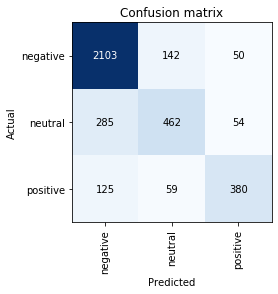

In [37]:
interp.plot_confusion_matrix()

In [0]:
learn.save('model.pth')

##Test Accuracy
Accuracy on unseen data

In [39]:
valid.shape[0]

3660

In [40]:
k = 0
for i in valid.iterrows():
    k = k+1
    if k==3:
        break
    else:
        print(i)
        
print('\n')
print(i[1]['text'])

(13059, airline_sentiment                                          positive
text                  i got a new reservation for tomorrow. Thanks!
Name: 13059, dtype: object)
(4026, airline_sentiment                                              neutral
text                  how about changing RNO -DEN non-stop In May (...
Name: 4026, dtype: object)


 Good morning.


In [0]:
from tqdm import tqdm_notebook as tqdm

In [42]:
pre = []
for sentiment in tqdm(valid.iterrows()):
    p = str(learn.predict(sentiment[1]['text'])[0])
    pre.append(p)
pre

['neutral',
 'negative',
 'positive',
 'negative',
 'negative',
 'neutral',
 'neutral',
 'positive',
 'negative',
 'negative',
 'negative',
 'negative',
 'positive',
 'positive',
 'negative',
 'negative',
 'negative',
 'neutral',
 'negative',
 'positive',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'neutral',
 'negative',
 'negative',
 'negative',
 'neutral',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'positive',
 'negative',
 'negative',
 'negative',
 'negative',
 'positive',
 'negative',
 'negative',
 'negative',
 'neutral',
 'negative',
 'negative',
 'negative',
 'positive',
 'negative',
 'neutral',
 'positive',
 'negative',
 'negative',
 'negative',
 'neutral',
 'positive',
 'negative',
 'negative',
 'negative',
 'neutral',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'neutral',
 'negative',
 'negative',
 'neutral',
 'negative',
 'positive',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative'

In [43]:
pred = pd.DataFrame(pre)
pred.sample(5)

,0
291,negative
270,negative
149,neutral
1188,negative
2037,negative


I used valid variable but it is actually test data

In [44]:
valid = valid.reset_index()
valid.sample(5)

,index,airline_sentiment,text
36,10613,negative,"your checkin at is a #shitshow, and the agen..."
2627,9583,neutral,can you add my KTN to an existing reservation?
457,831,negative,UA276 sitting at EWR nearly an hour after ske...
2995,515,positive,thanks
2720,14547,positive,Eliza &amp; I cheated on u with &amp; it was...
